In [1]:
knitr::opts_chunk$set(echo = FALSE)
suppressMessages(expr =  {
  if ("xfun" %in% row.names(installed.packages()) == FALSE) {
    install.packages("xfun")
  }

  if ("IRdisplay" %in% row.names(installed.packages()) == TRUE) {
    display_markdown <<- \(x) IRdisplay::display_markdown(as.character(x))
    display_html <<- \(x) IRdisplay::display_html(as.character(x))
  } else {
    display_markdown <<- knitr::asis_output
    display_html <<- knitr::asis_output
  }

xfun::pkg_attach(
    c("tidyverse",
      "polspline",
      "patchwork",
      "magrittr",
      "bayesplay",
      "knitr",
      "bayesplay"),
      install = TRUE)

})

table_format <- "html"


# Criticisms of *p* values

People have written lots of criticisms of *p*-values. A lot of these are of the
form "*p*-values are bad because they don't do X", where X is not a design
feature of frequentist inference. I'm not interested in these kinds of
criticisms, because they seem pretty meaningless. Instead, I think that if we
are going to criticise *p*-values it is better to look at the design features
of frequentist inference and find fault there.

So what are the design features? In the last section, we saw how frequentist
inference was very good at controlling the kinds of mistakes we made in our
treasure hunt. To do this, all we needed was a model of how our treasure
detecting device operated. If we only wanted to control *false positives* all
we needed was a model of how it operated in the absence of treasure—we didn’t
even need to know how it behaved when there was treasure around! To build this
model we needed one bit of information—that the dial *on average* pointed at 0
when there was no treasure. The whole model could then be built up by running
lots of simulations (or pretend experiments) where this parameter (the average
reading in the absence of treasure) was the only parameter we needed to set.
Just doing this allows us to precisely set an upper-bound on how often we make
false positives. That's a pretty powerful property, and it all comes from such
a simple principle.

But are there some issues with this simple principle? We can try explore it a
bit more and see where things start to break.

## Same measurements from different devices

Let's imagine a new scenario. As before, you have a treasure hunting device
(we'll call it $d_1$). You're using $d_1$ to hunt for treasure, and using the
readings to decide whether to dig or not. At your first treasure hunting spot,
you record the measurements: 1, 0, 1, 3, 0, 1, 4, -1, 3, 4. You then average,
and scale these measurements and get a *t* value of approximately 2.848. You
compare this to what you found in your imaginary experiments and find *p* =
.019. According to your rule, that means you dig. For far so good.

However, before you start digging, I run up to you and tell you that device
$d_1$ is broken. I tested it before you left, and found that $d_1$ is incapable
of measuring values bigger than 6. You look at your measurements again, and to
your relief, they don't go anywhere near 6. Your highest measurement is only 4.
But should you worry that the device couldn't register values of 6 or higher?
And if so, why?

More generally, how would this fault with the device influence your treasure
hunting strategy and would it change your view of when you think you should
start digging? The intuition here might be a little unclear, so let's modify
the example a little bit.

In the modified example, you want to be extra careful to avoid taking a broken
device with you, so you take two measurement devices ($d_1$ and $d_2$). The
devices are identical and, indeed, when you look at the measurements you can
see that they've recorded an identical set of 10 numbers. Because the
measurements are the same, you just pick whichever device and work out your
scaled reading and decide whether to dig.

But not so fast, I again tell you that $d_1$ is actually broken and it is
incapable of recording measurements higher than 6. I also tell you $d_2$ is
working perfectly. What does this do to your inference? Does your inference
change depending on whether you decided to look at $d_1$ or $d_2$? Remember,
that the actual numbers produced by both machines are identical.

If you want to be a good *frequentist* then the answer to this question is a
resounding *yes*. Even though $d_1$ and $d_2$ produced the exact same
measurements, and despite these measurements being accurate, your inference
will depend on the device you decided to look at. But why? Understanding the
answer to this means going back to the sampling distribution we generated by
running pretend experiments. Let's run some new pretend experiments for $d_1$
and $d_2$. The stimulations for $d_1$ will be modified slightly so that all
values higher than 6 will be replaced with a 6.

In [2]:
# code for simulated experiments for D1

run_exp_d1 <- function() {
  n <- 10
  data <- runif(n, -20, 20)

  # replace all values values greater than 6 with 6
  data <- map_dbl(data, function(x) ifelse(x > 6, 6, x))
  m <- mean(data)
  s <- sd(data)
  m / (s / sqrt(n))
}

# code for simulated experiments for D2

run_exp_d2 <- function() {
  n <- 10
  data <- runif(n, -20, 20)

  m <- mean(data)
  s <- sd(data)
  m / (s / sqrt(n))
}




In [3]:
# run the simulations

no_of_exps <- 1000

d1_exps <- map_dbl(1:no_of_exps, function(x) {
  run_exp_d1()
})

d2_exps <- map_dbl(1:no_of_exps, function(x) {
  run_exp_d2()
})




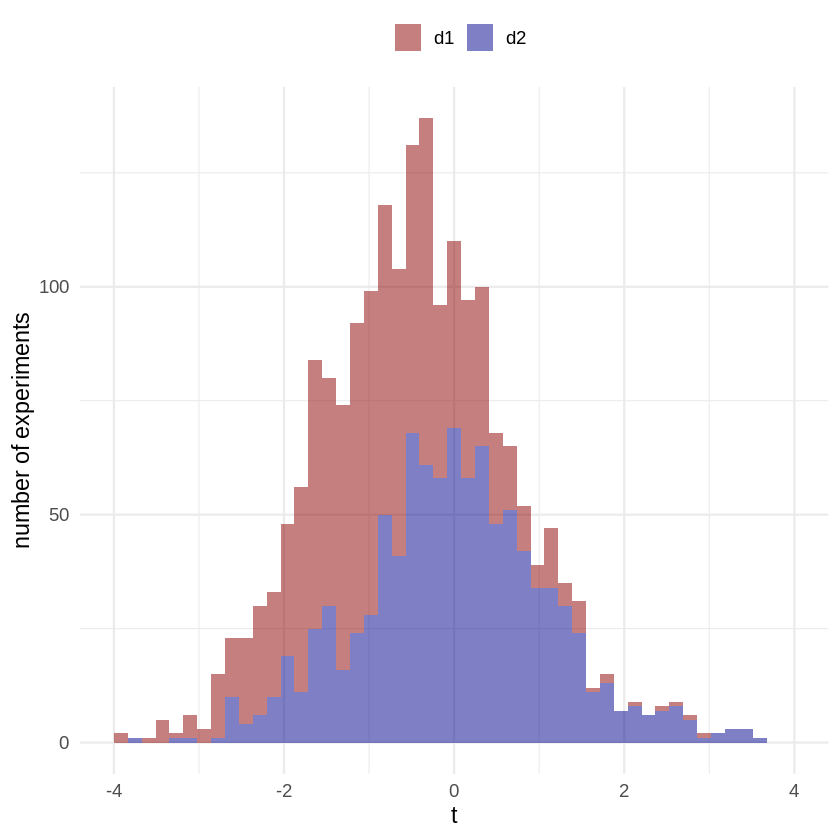

In [4]:
# draw distributions for D1 and D2

(tibble(d1 = d1_exps, d2 = d2_exps) %>%
  pivot_longer(cols = c("d1", "d2"), values_to = "x") %>%
  ggplot(aes(x = x, fill = name)) +
  geom_histogram(alpha = .5, bins = 50, na.rm = TRUE) +
  xlim(c(-4, 4)) +
  scale_fill_manual(
    values = c("d1" = "darkred", "d2" = "darkblue"),
    name = NULL
  ) +
  theme_minimal(14) +
  theme(legend.position = "top") +
  labs(y = "number of experiments", x = "t"))




As you can see, the distributions are different. This is because in those
pretend experiments, the devices would behave differently. In our actual
experiment (this treasure hunt), they didn't behave differently. They behaved
exactly the same, and both behaved accurately. Remember, these distributions
are what we use to make a judgement about whether our reading is surprising or
not. We mark out sections of these distributions to find the range of values
that are surprising and the range of values that are unsurprising. Because the
shape of these distributions are different, the ranges that we mark out on each
of them will be different. And consequently what counts as a
surprising/unsurprising value on one distribution might not count as a
surprising/unsurprising value on the other one.

If you’re being a frequentist then there's no getting away from the fact that
because the devices have the *potential* to behave differently in situations
other than the current situation, this *potential difference* must be accounted
for. They factor into the calculation of the *p* value by changing the
distributions and, therefore, we need to take account of these potential events
in our inferences if we want to maintain our error control properties.

For some, the influence of imaginary events is madness. Jeffreys described this
"madness" as follows:

> What the use of P implies, therefore, is that a hypothesis that may be true
> may be rejected because it has not predicted observable results that have not
> occurred. This seems a remarkable procedure (Jeffreys, 1961, p. 385)

## The universe of possible events

To see another example of how potential events can influence inferences, let us
examine a different scenario. In this scenario, we’re going to make judgements
about the fairness of a coin (fair coins being defined as coins that show heads
with P(heads) = 0.5). We'll use the same procedure as our treasure hunting
device. We will flip a coin that we *know* is fair a set number of times (let's
say 10 times). We then count up **x** heads out of our total of **n** flips. We
then repeat the procedure many many times. We can use this procedure to
generate a distribution of possible data. Again, we can just simulate this.

In [5]:
# define function for flipping coins
# set default to 10 flips with a fair coin
do_flips <- function(n_flips = 10, pr_heads = .5) {
  # generate n_flips bernoulli trials and count number of heads
  tibble(n = n_flips) %>%
    mutate(h = sum(rbernoulli(n, pr_heads)), t = n - h)
}




In [6]:
# run this chunk to actually run the simulations!
n_flips <- 10
pr_heads <- .5
all_flips <- map_dfr(1:no_of_exps, function(x) do_flips(n_flips, pr_heads))




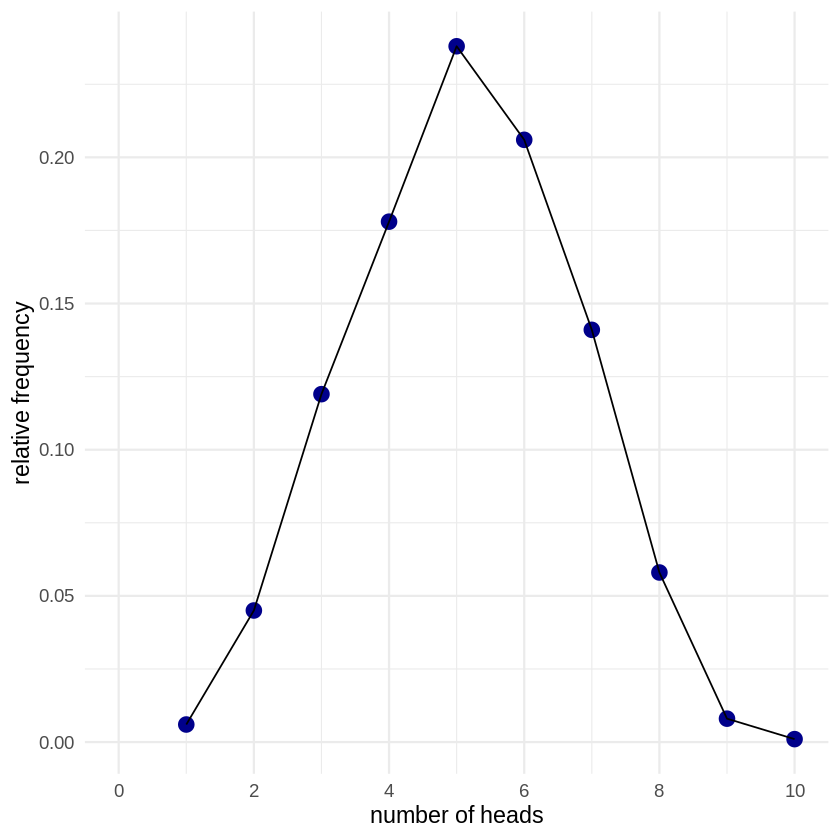

In [7]:
# plot the distribution of results from the simulated experiments
all_flips_summary <- all_flips %>%
  add_count(name = "total") %>%
  group_by(h, total) %>%
  summarise(d_heads = n(), .groups = "drop") %>%
  mutate(d_heads = d_heads / total) %>%
  ungroup()

(ggplot(all_flips_summary, aes(x = h, y = d_heads)) +
  geom_point(size = 4, colour = "darkblue") +
  geom_line() +
  theme_minimal(14) +
  scale_x_continuous(
    name = "number of heads",
    limits = c(0, 10), breaks = seq(0, 10, 2)
  ) +
  scale_y_continuous(name = "relative frequency"))




Armed with this distribution, we can start making judgements about actual data.
To produce some real data, I'll flip the coin I want to test and, at the end,
I’ll count up the number of heads. Let's say that I got 8 heads and 2 tails.
Now you can make a judgement about whether this data is surprising or not. To
do this, all you need to do is compare it to the simulated results above.

In [8]:
# compare current results to simulated results to see whether it is surprising
x <- 8 # the number of heads in our current sample

# use a binomial test instead of using the simulated distribution
coin_flip_v1_p <- round(binom.test(x, n_flips, pr_heads)$p.value, 3)

glue::glue("The *p* value for {x} heads in {n_flips} flips is {coin_flip_v1_p}.

This result is {if_else(coin_flip_v1_p > 0.05, 'not surprising','surprising')}
on the assumption that the coin is fair (i.e., P(heads) =
{pr_heads})") %>%
  display_markdown()




The *p* value for 8 heads in 10 flips is 0.109.

This result is not surprising
on the assumption that the coin is fair (i.e., P(heads) =
0.5)

But save your judgement for now, because there's something that I have
neglected to tell you. My plan wasn't to flip the coin 10 times. Instead, I
decided that I would just flip the coin until it came up tails twice, and it
just so happened that on this occasion this meant that I flipped the coin 10
times.

Does this fact change your inference? If our inferences are based on comparing
our actual data to possible data then we need to examine whether this sampling
rule changes the possible data that could have been generated. That is, we need
to take into account whether the data was generated by deciding to flip the
coin 10 times or whether it just so happened that I flipped the coin 10 times,
but really “in my head” I was going to stop when I got 2 tails. To so see why
we need to re-run the simulations. In the new simulations for each sample we’ll
continue to flip the coin until it comes up with 2 heads, and then we'll stop.
Sometimes this will mean that the coin is flipped 10 times, but sometimes we
might flip it more, and sometimes we might flip it less. 

In [9]:
# define function for new simulation. stop after stop_at heads
do_flips_until <- function(stop_at = 2, pr_heads = 0.5) {
  tails <- 0
  flips <- 0
  while (tails <= (stop_at - 1)) {
    tails <- tails + rbernoulli(1, pr_heads)
    flips <- flips + 1
  }
  return(flips)
}




In [10]:
# run the actual simulations
stop_at <- 2

all_flips_v2 <- map_dbl(1:no_of_exps, function(x) {
  do_flips_until(stop_at, pr_heads)
})




We now can count up the relative frequency of getting 2 heads after 2 flips,
after 3 flips, 4 flips, and so on. And we can draw a plot of this distribution.

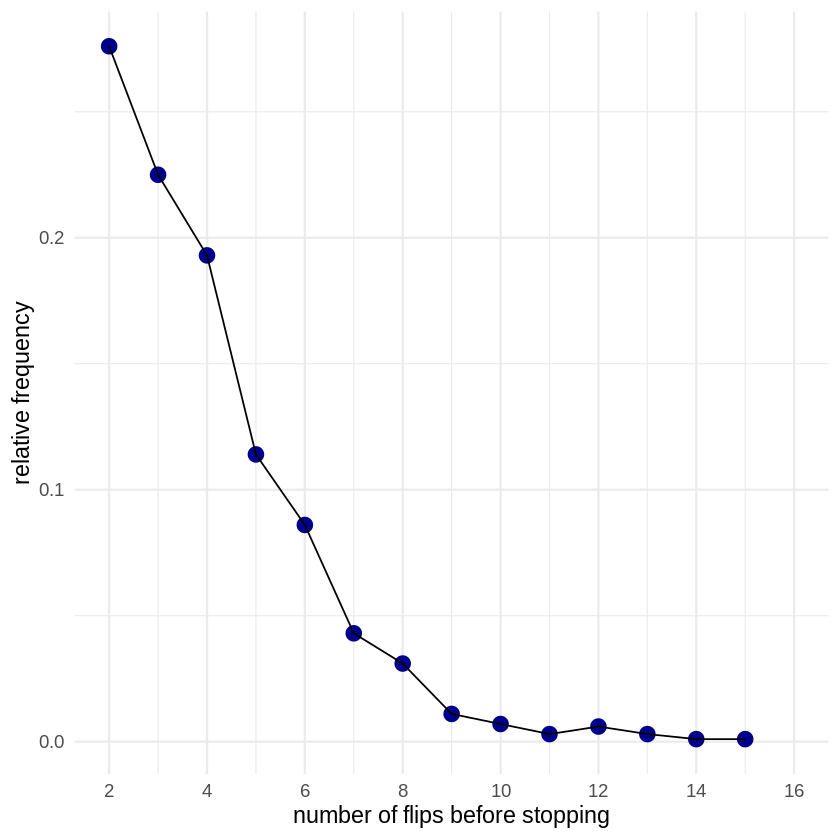

In [11]:
# plot the distribution of results from the simulation experiments

# make a frequency table
all_flips_v2_freq <- enframe(all_flips_v2) %>%
  group_by(value) %>%
  summarise(n = n(), .groups = "drop") %>%
  rename(flips = value, count = n) %>%
  mutate(freq = count / sum(count))

# make the actual plot
(all_flips_v2_freq %>% ggplot(aes(x = flips, y = freq)) +
  geom_point(size = 4, colour = "darkblue", na.rm = TRUE) +
  geom_line(na.rm = TRUE) +
  theme_minimal(14) +
  scale_x_continuous(
    name = "number of flips before stopping",
    limits = c(2, 16),
    breaks = seq(2, 16, 2)
  ) +
  scale_y_continuous(name = "relative frequency"))




From this new distribution, we can now ask: How often would you need to flip a
fair coin 10 or more times before you got two heads? That is, is it surprising
that we had to flip it this many times? Let's see how the inference differs.

In [12]:
# calculate a p value based on our new simulations
# use a negative-binomial sampling distribution for accuracy

freq <- dnbinom(n_flips:10000 - stop_at, stop_at, 0.5)
coin_flip_v2_p <- round(sum(freq), 3)

glue::glue("For a fair coin (P(heads) = {pr_heads}),
about {(1 - coin_flip_v2_p) * 100}% of experiments would end before we got to
{n_flips} flips. Only {coin_flip_v2_p * 100}% of experiments would run this
long. Therefore, our result is {if_else(coin_flip_v2_p < 0.05, 'surprising!',
'not surprising.')}") %>%
  display_markdown()


For a fair coin (P(heads) = 0.5),
about 98% of experiments would end before we got to
10 flips. Only 2% of experiments would run this
long. Therefore, our result is surprising!

## Summary

What these two examples (the broken device, and stopping rule example) show is
that even when presented with the **same data** the inferences we make about
that data will be different if the realm of **possible**, but **not actual**
results are different. That is, non-existent results influence our inferences.
A broken device that still behaved accurately when we used it influences our
inferences, and what we had going on inside our head when we collected our data
also made a difference. Based on this, we can go ahead to imagine even more
ridiculous examples.

For example, imagine that I build a device that is going to flip a coin to
decide whether 1) to flip the coin n times or 2) flip it until it comes up
tails x times. The device makes a decision, flips the coin, and it just so
happens that on this occasion we get 8 heads and 2 tails. How do I analyse this
set of data? Does the realm of possible data include the machine that makes the
decision? What if I know what decision the device made? Do I still have to take
into account the experiment that wasn't performed? And what if I have the
results of two experiments, one that was performed as part of a mixture (using
a machine to decide which of the two experiments would be performed) and one
that was not performed as part of a mixture. If they yield the same data, then
does the fact that one was part of a mixture mean that the conclusions should
be different? For a frequentist, these can be pretty uncomfortable questions!
In the next section we’re going to see if we can find a way out of this bind.